In [1]:
# Imports
import torch
import torchvision
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
# Configs
plt.style.use('fivethirtyeight')
torch.manual_seed(0)
np.random.seed(0)
img_dir = './Data'
target_size = 64

In [17]:
# Define our data loader
# https://pytorch.org/vision/stable/transforms.html
# TODO: consider adding noise as part of the transformation process
class ImageDataset(Dataset):
    def __init__(self, img_dir, target_size):
        self.img_dir = img_dir
        self.transform = v2.Compose([
            v2.Resize(size=(target_size, target_size), antialias=True),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize (recommended for torch image datasets)
        ])
        self.imageLabels = os.listdir(img_dir)

    def __len__(self):
        return len(self.imageLabels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imageLabels[idx])
        image = torchvision.io.read_image(img_path)
        # label = self.imgLabels[idx]
        if self.transform:
            image = self.transform(image)
        return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

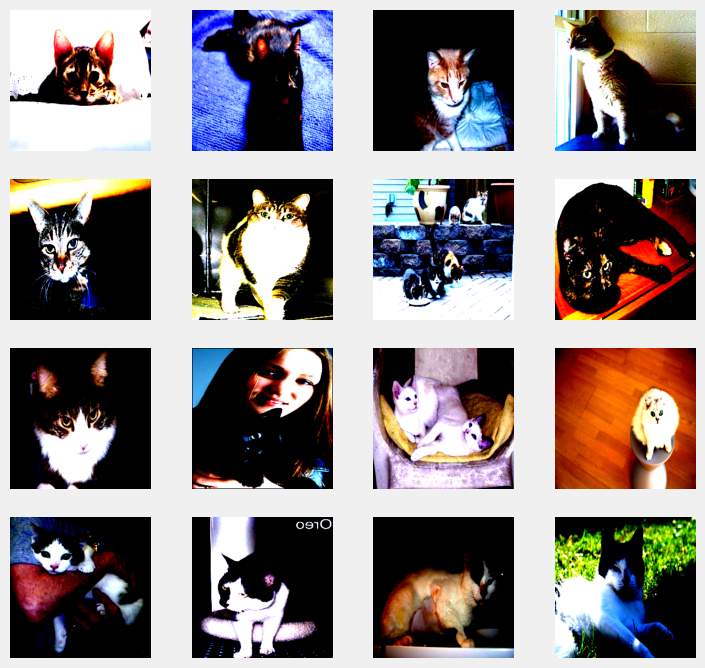

In [33]:
# Test the image loader
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
training_data = ImageDataset(img_dir, 256)

figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(np.rot90(img.T, k=3))
plt.show()